In [1]:
import os
cwd = os.getcwd().replace('/reinforcement_learning', '')
os.chdir(cwd)

In [2]:
from dataset import Dataset
import gym
import gym_anytrading
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3 import A2C, PPO, DQN # select model
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.cmd_util import make_vec_env
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import quantstats as qs


/home/serg/CRYPTO/lib/python3.10/site-packages/stable_baselines3/common/cmd_util.py:5: FutureWarning: Module ``common.cmd_util`` has been renamed to ``common.env_util`` and will be removed in the future.
  warnings.warn(


In [3]:
data_binance = Dataset().get_data(days=90, ticker='BTCUSDT', ts='5m')

In [4]:
df = data_binance.copy()[['open', 'high', 'low', 'close', 'volume']]
df = df.reset_index()
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df.set_index('Date')

In [5]:
window_size = 50
start_index = window_size
end_index = len(df)


def create_env(df, start_index, end_index, window_size):
    env = gym.make('forex-v0', df=df,  frame_bound=(start_index,
                   end_index), window_size=window_size)
    env.trade_fee = 0
    return env


def env_maker():
    return create_env(df, start_index, end_index, window_size)


### Create Agent model

In [6]:
env = make_vec_env(lambda: env_maker(), n_envs=100) # 1000
model = A2C(MlpPolicy, env, verbose=1) # PPO(MlpPolicy, env, verbose=1)

Using cuda device


### Random evolute before training

In [7]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-48087100.00 +/- 0.00


### Train Agent model

In [8]:
model.learn(total_timesteps=10000000) # 

------------------------------------
| time/                 |          |
|    fps                | 29636    |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 50000    |
| train/                |          |
|    entropy_loss       | -0.577   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 5.4e+04  |
|    value_loss         | 2.55e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 27982     |
|    iterations         | 200       |
|    time_elapsed       | 3         |
|    total_timesteps    | 100000    |
| train/                |           |
|    entropy_loss       | -0.517    |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | -3.19e+05 |
|    value_loss         | 

#### Evaluate Agent model after training

In [9]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:0.00 +/- 0.00


#### Save Agent model

In [11]:
import os

# Create save dir
save_dir = "/tmp/gym/"
os.makedirs(save_dir, exist_ok=True)

model.save(f"{save_dir}/agentModel")

### Evaluate Agent model after training

info {'total_reward': 46799699.9999988, 'total_profit': 1.2073772974627315, 'position': 1}


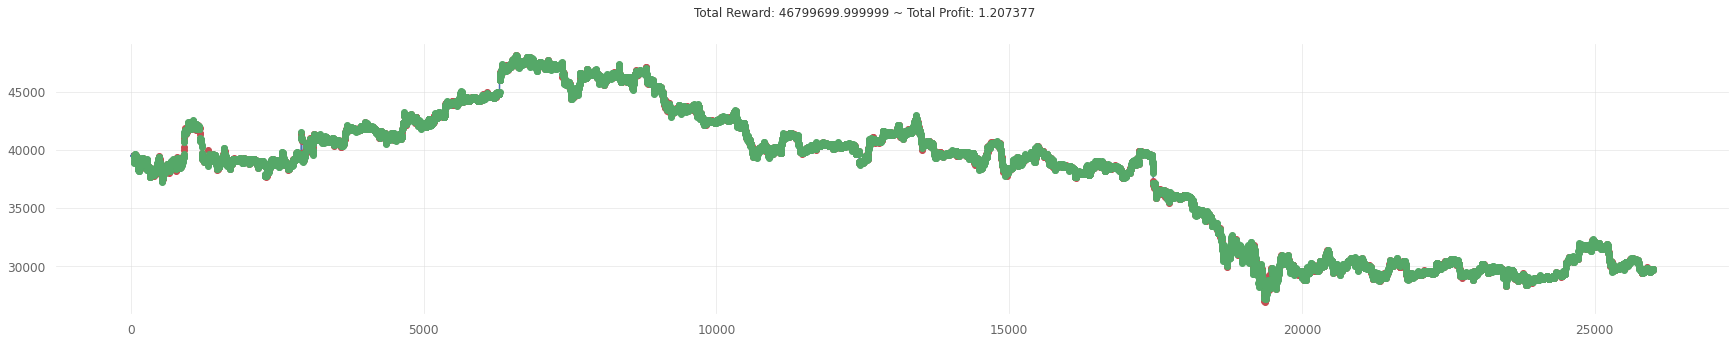

In [33]:
env = gym.make('forex-v0', df=df, frame_bound=(start_index,
               end_index), window_size=window_size)
env.trade_fee = 0

obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(30, 5))
# plt.cla()
env.render_all()
plt.show()


### Report Agent model

                           Strategy
-------------------------  ----------
Start Period               2022-03-06
End Period                 2022-06-04
Risk-Free Rate             0.0%
Time in Market             24.0%

Cumulative Return          20.58%
CAGR﹪                     113.57%

Sharpe                     0.1
Prob. Sharpe Ratio         84.79%
Smart Sharpe               0.1
Sortino                    0.14
Smart Sortino              0.14
Sortino/√2                 0.1
Smart Sortino/√2           0.1
Omega                      1.05

Max Drawdown               -15.66%
Longest DD Days            36
Volatility (ann.)          1.99%
Calmar                     7.25
Skew                       -0.31
Kurtosis                   164.23

Expected Daily %           0.0%
Expected Monthly %         4.79%
Expected Yearly %          20.58%
Kelly Criterion            2.19%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.21%
Expected Shortfall (cVaR)  -0.21%

Max Consecutive Wins       1


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-05-12,2022-06-01,2022-06-04,23,-15.656846,-15.219988
2,2022-03-07,2022-03-10,2022-04-13,36,-12.336302,-11.556677
3,2022-04-14,2022-04-21,2022-04-26,12,-6.144291,-5.601038
4,2022-05-10,2022-05-11,2022-05-11,0,-3.770757,-3.424828
5,2022-05-10,2022-05-10,2022-05-10,0,-3.540383,-3.511568


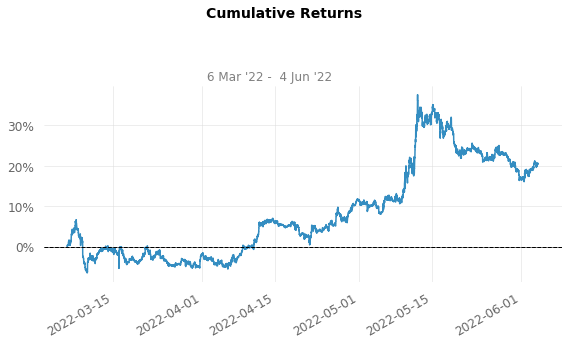

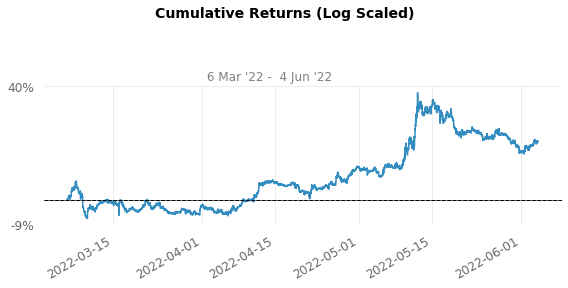

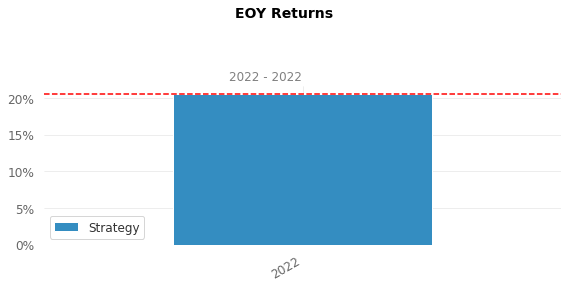

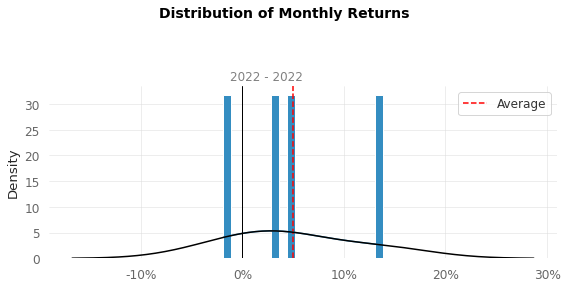

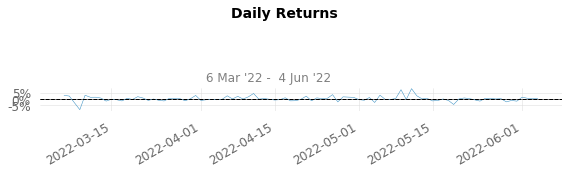

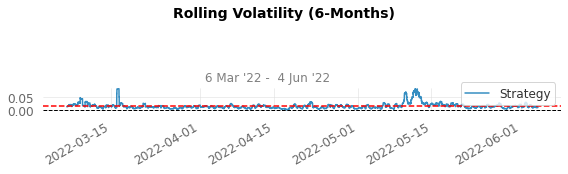

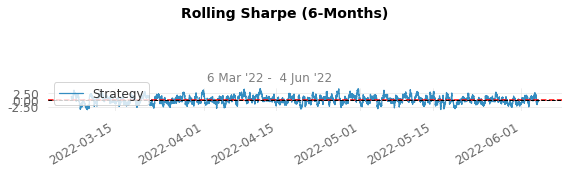

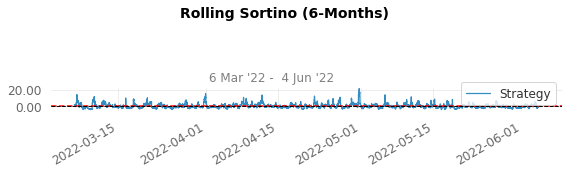

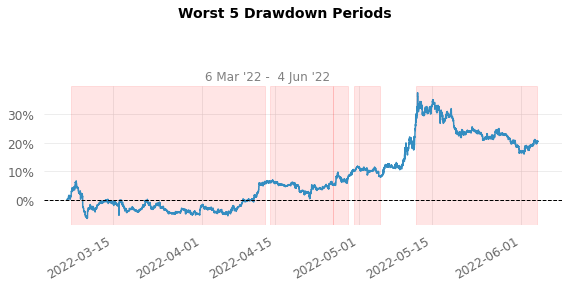

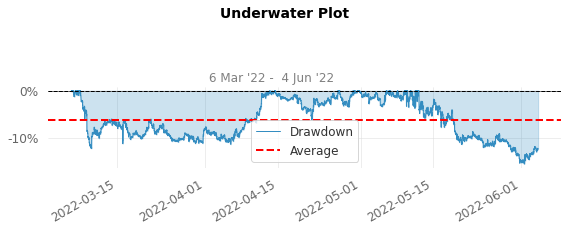

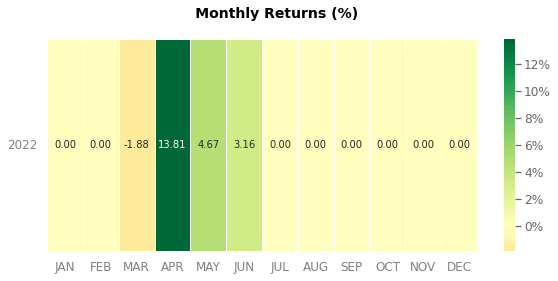

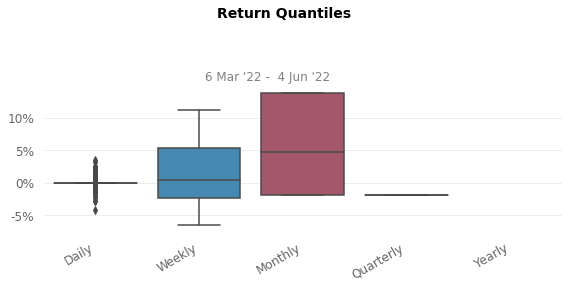

In [34]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
# qs.reports.html(returns, output='reinforcement_learning/a2c_quantstats.html')


In [56]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:479400.00 +/- 0.00
